In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchviz import make_dot, make_dot_from_trace
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn.functional as F
from torchsummary import summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [2]:
# Loading and normalizing the data.
# Define transformations for the training and test sets
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 dataset consists of 50K training images. We define the batch size of 10 to load 5,000 batches of images.
batch_size = 10
number_of_labels = 10 

# Create an instance for training. 
# When we run this code for the first time, the CIFAR10 train dataset will be downloaded locally. 
train_set =CIFAR10(root="./data",train=True,transform=transformations,download=True)

# Create a loader for the training set which will read the data within batch size and put into memory.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
print("The number of images in a training set is: ", len(train_loader)*batch_size)

# Create an instance for testing, note that train is set to False.
# When we run this code for the first time, the CIFAR10 test dataset will be downloaded locally. 
test_set = CIFAR10(root="./data", train=False, transform=transformations, download=True)

# Create a loader for the test set which will read the data within batch size and put into memory. 
# Note that each shuffle is set to false for the test loader.
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
print("The number of images in a test set is: ", len(test_loader)*batch_size)

print("The number of batches per epoch is: ", len(train_loader))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
The number of images in a training set is:  50000
Files already downloaded and verified
The number of images in a test set is:  10000
The number of batches per epoch is:  5000


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

torch.Size([10, 3, 32, 32])


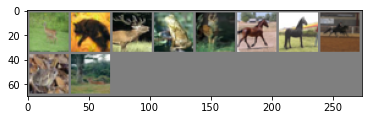

4 3 4 6 4 7 7 7


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(8)))

In [ ]:
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [3]:
class ConvBlock(nn.Module):
    
    def __init__(self, input_dim, block_dim):
        super(ConvBlock, self).__init__()
        self.input_dim = input_dim
        self.output_dim = block_dim*4
        
        self.block = nn.Sequential(
            nn.Conv2d(input_dim,block_dim,1,bias=False),
            nn.Conv2d(block_dim,block_dim,3,padding=1,bias=False),
            nn.Conv2d(block_dim,self.output_dim,1,bias=False)
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(input_dim, self.output_dim, 1,bias=False)
        )
        
    def forward(self, x):
        tmp = self.block(x)
        if self.input_dim != self.output_dim:
            res = self.downsample(x)
        else:
            res = x
        tmp = tmp + res
        return tmp

In [4]:
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet, self).__init__()
        self.foot = nn.Sequential(
            nn.Conv2d(3,64,7,stride=2, padding = 3),
            nn.MaxPool2d(3,stride=2)
        )
        self.block1 = nn.Sequential(
            ConvBlock(64,64),  #(64,64) => (64,64) => (64,256)
            ConvBlock(256,64), #(256,64) => (64,64) => (64,256) 
            ConvBlock(256,64)  #(256,64) => (64,64) => (64,256)
        )
        self.block2 = nn.Sequential(
            ConvBlock(256,128), #(256,128) => (128,128) => (128,512)
            ConvBlock(512,128), #(512,128) => (128,128) => (128,512)
            ConvBlock(512,128), #(512,128) => (128,128) => (128,512)
            ConvBlock(512,128), #(512,128) => (128,128) => (128,512)
            nn.MaxPool2d(2,2)
        )
        self.block3 = nn.Sequential(
            ConvBlock(512,256), #(512,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            nn.MaxPool2d(2,2)
        )
        self.block4 = nn.Sequential(
            ConvBlock(1024,512),#(1024,512) => (512,512) => (512,2048)
            ConvBlock(2048,512),#(2048,512) => (512,512) => (512,2048)
            ConvBlock(2048,512),#(2048,512) => (512,512) => (512,2048)
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Linear(2048,10)
        )

        
    def forward(self, x):
        tmp = self.foot(x)
        tmp = self.block1(tmp)
        tmp = self.block2(tmp)
        tmp = self.block3(tmp)
        tmp = self.block4(tmp)
        tmp = torch.flatten(tmp,start_dim=1)
        tmp = self.fc(tmp)

        return tmp

In [5]:
model = ResNet()
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
model.to(device)

The model will be running on cuda:0 device


ResNet(
  (foot): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (downsample): Sequential(
        (0): Conv2d(256, 256, kerne

In [ ]:
My_model_summary = ResNet()
summary(My_model_summary,(3,32,32),device = "cpu")

In [11]:
class ResNet101(nn.Module):
    def __init__(self):
        super(ResNet101, self).__init__()
        self.foot = nn.Sequential(
            nn.Conv2d(3,64,7,stride=2, padding = 3),
            nn.MaxPool2d(3,stride=2)
        )
        self.block1 = nn.Sequential(
            ConvBlock(64,64),  #(64,64) => (64,64) => (64,256)
            ConvBlock(256,64), #(256,64) => (64,64) => (64,256) 
            ConvBlock(256,64)  #(256,64) => (64,64) => (64,256)
        )
        self.block2 = nn.Sequential(
            ConvBlock(256,128), #(256,128) => (128,128) => (128,512)
            ConvBlock(512,128), #(512,128) => (128,128) => (128,512)
            ConvBlock(512,128), #(512,128) => (128,128) => (128,512)
            ConvBlock(512,128), #(512,128) => (128,128) => (128,512)
            nn.MaxPool2d(2,2)
        )
        self.block3 = nn.Sequential(
            ConvBlock(512,256), #(512,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            ConvBlock(1024,256),#(1024,256) => (256,256) => (256,1024)
            nn.MaxPool2d(2,2)
        )
        self.block4 = nn.Sequential(
            ConvBlock(1024,512),#(1024,512) => (512,512) => (512,2048)
            ConvBlock(2048,512),#(2048,512) => (512,512) => (512,2048)
            ConvBlock(2048,512),#(2048,512) => (512,512) => (512,2048)
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Linear(2048,10)
        )
    def forward(self, x):
        tmp = self.foot(x)
        tmp = self.block1(tmp)
        tmp = self.block2(tmp)
        tmp = self.block3(tmp)
        tmp = self.block4(tmp)
        tmp = torch.flatten(tmp,start_dim=1)
        tmp = self.fc(tmp)

        return tmp

In [ ]:
model = ResNet101()
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
model.to(device)

In [6]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [7]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./ResNet.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0



    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # save the best model 
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
    outputs = model(images)
    
    _, predicted = torch.max(outputs, 1)
    
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [9]:
if __name__ == "__main__":
    
    # Let's build our model
    train(1)
    print('Finished Training')

    # Test which classes performed well
    #testModelAccuracy()
    
    # Let's load the model we just created and test the accuracy per label
    model = ResNet()
    path = "ResNet.pth"
    model.load_state_dict(torch.load(path))

    # Test with batch of images
    testBatch()

[1,  1000] loss: 262714564718872608.000
[1,  2000] loss: 38431683785523.203
[1,  3000] loss: 10517990381846.527
[1,  4000] loss: 4795687693254.656
[1,  5000] loss: 2993516230868.992
For epoch 1 the test accuracy over the whole test set is 11 %
Finished Training


NameError: name 'torchvision' is not defined